In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp # I couldn't get this one to work
from cvxopt import matrix as cv_matrix
from cvxopt import solvers as cv_solvers
from sklearn.svm import SVC # for checking


## Problem 3 - SVM Implementation
- Implement the SVM (both domain adaptation SVM and normal SVM) using a quadratic program
- Do not need to build a classifier (i.e. solve for bias)
- Find W_T (target hyperplane) and W_S (source hyperplane)
- To find weight vectors, solve a quadratic programming problem and learn how to solve optimization task:
    - CVXOPT(https://cvxopt.org/)
    - PyCVX (https://www.cvxpy.org/install/)

### Resources:
- Quadratic Program Thoughts
- General SVM: https://scikit-learn.org/stable/modules/svm.html
- https://xavierbourretsicotte.github.io/SVM_implementation.html

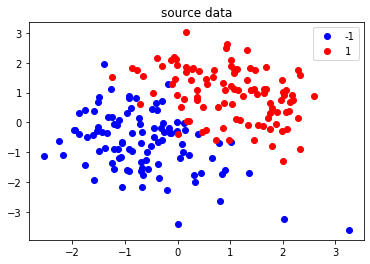

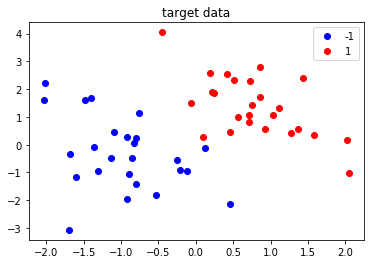

In [3]:
# read data
s_arr = pd.read_csv('hw3_data/source_train.csv', header=None).to_numpy()
t_arr = pd.read_csv('hw3_data/target_train.csv', header=None).to_numpy()

# plot
# color list for graphing
color_list = ['b', 'r']
cla_l = [-1, 1]
for cla in range(2):
    lab = str(cla_l[cla])
    plt.plot(s_arr[:,0][s_arr[:,-1] == cla_l[cla]], s_arr[:,1][s_arr[:,-1] == cla_l[cla]], 'o', c=color_list[cla],label=lab)

plt.legend()
plt.title('source data')
plt.show()

# plot
# color list for graphing
color_list = ['b', 'r']
cla_l = [-1, 1]
for cla in range(2):
    lab = str(cla_l[cla])
    plt.plot(t_arr[:,0][t_arr[:,-1] == cla_l[cla]], t_arr[:,1][t_arr[:,-1] == cla_l[cla]], 'o', c=color_list[cla],label=lab)

plt.legend()
plt.title('target data')
plt.show()

1. solve for alpha source using a quad program

In [4]:
# 1. solve for alpha source using a quad program
    # form: min (1/2 * alpha.T * H * alpha + F.T * alpha)
        # s.t. A*alpha = b, Q*alpha <= d

# free parameters
C, B = 10, 0 # B = 1 if domain adaptive SVM, else B = 0

X = s_arr[:,:-1]
# print(X.shape)
y = s_arr[:,-1]
m, n = X.shape
y = y.reshape(-1,1) * 1.
# print(y.shape)

    # Hij = (yi * yj * xi.T * xj) --> shape = m*m
H = cv_matrix(np.matmul(y,y.T) * np.matmul(X,X.T))
    # F = vector of -1 for generic SVM --> shape = m,1
F = cv_matrix(np.ones((m, 1)) * -1)
    # A = vector of y, b = 0 (from constraint sum(yi*alpha) = 0) --> A shape = 200,1 , b shape = 1
A, b = cv_matrix(y.reshape(1, -1)), cv_matrix(np.zeros(1))
    # Q = I matrix of -1 and 1, stacked; d = vector matrix of 0 and C  --> Q shape = m*2m, d shape = 2m 
        # note more commonly referred to as G = Q, and h = d
Q, d = cv_matrix(np.vstack((np.eye(m) * -1, np.eye(m)))), cv_matrix(np.hstack((np.zeros(m), np.ones(m) * C)))

solution = cv_solvers.qp(H, F, Q, d, A, b)
alphas = np.array(solution['x'])

     pcost       dcost       gap    pres   dres
 0: -2.8056e+02 -1.3709e+04  4e+04  8e-01  2e-14
 1: -1.5968e+02 -3.5932e+03  5e+03  7e-02  2e-14
 2: -1.2499e+02 -7.8459e+02  8e+02  9e-03  2e-14
 3: -1.7810e+02 -3.7504e+02  2e+02  2e-03  1e-14
 4: -1.9469e+02 -3.3774e+02  2e+02  1e-03  1e-14
 5: -2.1025e+02 -2.9579e+02  9e+01  6e-04  1e-14
 6: -2.0893e+02 -2.8104e+02  7e+01  3e-04  1e-14
 7: -2.1499e+02 -2.7779e+02  6e+01  2e-04  1e-14
 8: -2.3154e+02 -2.5248e+02  2e+01  5e-05  2e-14
 9: -2.3172e+02 -2.4828e+02  2e+01  2e-05  2e-14
10: -2.3606e+02 -2.4070e+02  5e+00  7e-07  2e-14
11: -2.3652e+02 -2.4052e+02  4e+00  5e-07  1e-14
12: -2.3765e+02 -2.3861e+02  1e+00  2e-08  2e-14
13: -2.3810e+02 -2.3811e+02  1e-02  2e-10  2e-14
14: -2.3810e+02 -2.3810e+02  1e-04  2e-12  1e-14
Optimal solution found.


2. solve for ws using closed form ws

In [5]:
# 2. solve for ws using closed from ws
    # ws = sum(alphai*yi*xi) (should be a 1xm vector)

ws = np.zeros(2)
for j in range(m):
    # print(alphas[j])
    ws += alphas[j]*y[j]*X[j,:]

print('w source using for loop', ws)

w_s = ((y * alphas).T @ X).reshape(-1,1)
S = (alphas > 1e-4).flatten()
b = y[S] - np.dot(X[S], w_s)

print('w source using Q_Prog= ', w_s.flatten())

clf = SVC(C = 10, kernel = 'linear')
clf.fit(X, y.ravel()) 

print('w source using SKLearn ',clf.coef_.flatten())


w source using for loop [2.31500325 2.14257169]
w source using Q_Prog=  [2.31500325 2.14257169]
w source using SKLearn  [2.3138911  2.14154075]


3. solve for alpha target using a quad program

In [6]:
# 3. solve for alpha target using a quad program

# free parameters
C, B = 10, 1 # B = 1 if domain adaptive SVM, else B = 0

X = t_arr[:,:-1]
# print(X.shape)
y = t_arr[:,-1]
m, n = X.shape
y = y.reshape(-1,1) * 1.
# print(y.shape)

    # Hij = (yi * yj * xi.T * xj) --> shape = m*m
H = cv_matrix(np.matmul(y,y.T) * np.matmul(X,X.T))
    # F = vector of -(1 - B*yi*xi.T*w_s) for DA SVM --> shape = m,1
F = np.zeros(m).reshape(-1,1)
for i in range(F.shape[0]):
    # print(y[i].shape)
    # print(w_s.shape)
    # print(X[i,:].shape)
    # print(y[i]*np.matmul(X[i,:].T,w_s))
    F[i] = -(1 - B*y[i]*np.matmul(X[i,:].T,w_s))

print(F.shape)
F = cv_matrix(F)
    # A = vector of y, b = 0 (from constraint sum(yi*alpha) = 0) --> A shape = 200,1 , b shape = 1
A, b = cv_matrix(y.reshape(1, -1)), cv_matrix(np.zeros(1))
    # Q = I matrix of -1 and 1, stacked; d = vector matrix of 0 and C  --> Q shape = m*2m, d shape = 2m 
        # note more commonly referred to as G = Q, and h = d
Q, d = cv_matrix(np.vstack((np.eye(m) * -1, np.eye(m)))), cv_matrix(np.hstack((np.zeros(m), np.ones(m) * C)))

solution = cv_solvers.qp(H, F, Q, d, A, b)
alphas = np.array(solution['x'])


(50, 1)
     pcost       dcost       gap    pres   dres
 0: -2.5826e+01 -3.9444e+03  1e+04  1e+00  2e-15
 1:  4.4777e+01 -1.1862e+03  2e+03  8e-02  4e-15
 2:  3.6709e+01 -1.3060e+02  2e+02  7e-03  3e-15
 3:  4.9820e+00 -3.6256e+01  5e+01  1e-03  7e-16
 4: -8.3141e+00 -1.5697e+01  8e+00  2e-04  7e-16
 5: -1.1894e+01 -1.2316e+01  4e-01  5e-06  6e-16
 6: -1.2191e+01 -1.2195e+01  5e-03  5e-08  5e-16
 7: -1.2194e+01 -1.2194e+01  5e-05  5e-10  6e-16
 8: -1.2194e+01 -1.2194e+01  5e-07  5e-12  6e-16
Optimal solution found.


4. solve for wt using closed form wt

In [7]:
# 4. solve for wt using closed form wt
    # wt = sum(alphai*yi*xi) - Bws (should be a 1xn vector)

wt = np.zeros(2)
for j in range(m):
    # print(alphas[j])
    # print(y[j])
    # print(X[j,:])
    # print(w_s.shape)
    wt += alphas[j]*y[j]*X[j,:] - B*w_s.flatten()

print('w target using for loop', wt)


w target using for loop [-113.94564524 -106.3400826 ]
